# Coronavirus in Spain

This report returns the evolution in Spain of the measures
<ul>
    <li>cases</li>
    <li>recovered</li>
    <li>hospitalized</li>
    <li>icu</li>
    <li>deaths</li>
    <li>active</li>
    <li>new_cases/active</li>
</ul>
related to coronavirus. Each measure represent the number of individuals in each situation per 100000 people.
Granularity is day and data is also shown by CA (different autonomous communities of Spain).
Each measure is ordered in a descending order 
<ul>
    <li>to compare in the graphics autonomous comunities with similar values of measures</li>
    <li>and to identify easily which autonomous comunities have higher or lower measure values</li>
</ul>
The autonomies in the autonomic graphic are showed by descending order in the measure.
The report can be seen in [Binder](https://mybinder.org/v2/gh/JoanFerrerSerrat/Reports/master?filepath=Jupyter%2FCoronavirus_Spain.ipynb).

In [ ]:
# run only once
import sys
!{sys.executable} -m pip install pandas

In [ ]:
# run only once
import sys
!{sys.executable} -m pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
path_master = "https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/old_series/ccaa_covid19_##name##_long.csv"
path = "https://raw.githubusercontent.com/JoanFerrerSerrat/Reports/master/Source/CCAA_population.csv"
measures = ["cases", "recovered", "hospitalized", "icu", "deaths"]

In [3]:
# function to get sources
def retrieve_source_df(name_path, rename_column) :
    '''
    It returns a dataframe
    
    Args:
        name_path (str)            : string to be replaced in the path to get the correct path
        rename_column (dictionary) : dictionary with the original column names and the names wanted to rename to
        
    Returns:
        DataFrame
    '''
    # Columns needed of the DataFrame
    use_columns= ['fecha', 'CCAA', 'total']
    
    # Replacing ##name## in the path_master by the first parameter is the proper path 
    path = path_master.replace('##name##', name_path)
    result_df = pd.read_csv(path, parse_dates=['fecha'], usecols=use_columns, encoding='utf-8')
    
    # Swcond parameter is used to rename the fields of the daaframe
    result_df.rename(columns=rename_column, inplace=True)
    result_df =  result_df[result_df.CA != 'Total']
    result_df.set_index = ['date', 'CA']  
    
    return result_df

In [4]:
# get sources
coronavirus_cases_df = retrieve_source_df('casos', {'fecha' : 'date', 'CCAA' : 'CA', 'total' : 'cases'})
coronavirus_recovered_df = retrieve_source_df('altas', {'fecha' : 'date', 'CCAA' : 'CA', 'total' : 'recovered'})
coronavirus_hospitalized_df = retrieve_source_df('hospitalizados', {'fecha' : 'date', 'CCAA' : 'CA', 'total' : 'hospitalized'})
coronavirus_icu_df = retrieve_source_df('uci', {'fecha' : 'date', 'CCAA' : 'CA', 'total' : 'icu'})
coronavirus_deaths_df = retrieve_source_df('fallecidos', {'fecha' : 'date', 'CCAA' : 'CA', 'total' : 'deaths'})

In [5]:
# join all dataframes in one
coronavirus_df = pd.merge(coronavirus_cases_df, coronavirus_recovered_df, on=['date', 'CA'], how='outer')
coronavirus_df = pd.merge(coronavirus_df, coronavirus_hospitalized_df, on=['date', 'CA'], how='outer')
coronavirus_df = pd.merge(coronavirus_df, coronavirus_icu_df, on=['date', 'CA'], how='outer')
coronavirus_df = pd.merge(coronavirus_df, coronavirus_deaths_df, on=['date', 'CA'], how='outer')
coronavirus_df.fillna(0, inplace=True)

# change to the proper data types of the dataframe
datatype_ict={'cases':int, 'recovered':int, 'hospitalized':int, 'icu':int, 'deaths':int}
coronavirus_df = coronavirus_df.astype(datatype_ict)

In [6]:
# get custom data to get the population for each 
use_columns = ['CA', 'Population']
ccaa_df = pd.read_csv(path, sep=';', encoding='utf-8', usecols=use_columns) 
coronavirus_df = pd.merge(coronavirus_df, ccaa_df, on='CA', how='inner')

In [7]:
# Active
coronavirus_df["active"]=coronavirus_df["cases"]-np.where(coronavirus_df["recovered"].isnull(), 0, coronavirus_df["recovered"].isnull())-np.where(coronavirus_df["deaths"].isnull(), 0, coronavirus_df["deaths"].isnull())
measures.append('active')

In [8]:
# add new_cases/active column
acum_coronavirus_df = coronavirus_df.loc[:, ["date", "CA", "active"]].groupby(by=["CA", "date"]).sum().groupby(level=[0]).cumsum().reset_index()
acum_coronavirus_df.rename(columns={"active": "acum_active"}, inplace=True)
coronavirus_df = pd.merge(coronavirus_df, acum_coronavirus_df, on=["CA", "date"])

In [9]:
# Convert measure to number of individuals each 100000 citizens
scale = 100000

coronavirus_df["cases_100"] = scale*(coronavirus_df.cases/coronavirus_df.Population)
coronavirus_df["recovered_100"] = scale*(coronavirus_df.recovered/coronavirus_df.Population)
coronavirus_df["hospitalized_100"] = scale*(coronavirus_df.hospitalized/coronavirus_df.Population)
coronavirus_df["icu_100"] = scale*(coronavirus_df.icu/coronavirus_df.Population)
coronavirus_df["deaths_100"] = scale*(coronavirus_df.deaths/coronavirus_df.Population)
coronavirus_df["active_100"] = scale*(coronavirus_df.active/coronavirus_df.Population)

f_100 = lambda x : x + "_100"
measures_100 = list(map(f_100, measures))

In [11]:
# get  tiles so that in each graphic there are enough autonomous communities to compare data and at the same time they get readable
# each measure must be ordered in a descending order 
  # to compare in the graphics autonomous comunities with similar values of measures
  # and to identify easily which autonomous communities have higher or lower measure values
list_columns = ['date', 'CA']
list_columns.extend(measures_100)

rank_df = coronavirus_df.loc[: , list_columns].groupby(['CA']).last()

tile = lambda x : np.floor(1+(rank_df[x+"_100"].rank(ascending=False)-0.01)/4).astype(int)

tile_measures = []

for measure in measures:
    rank_df["tile_"+measure] = tile(measure)
    tile_measures.append("tile_"+measure)

rank_df = rank_df.loc[:,tile_measures]

In [12]:
coronavirus_df = pd.merge(coronavirus_df, rank_df, on=['CA'], how='inner')
coronavirus_spain_df = coronavirus_df.groupby("date").sum().reset_index()

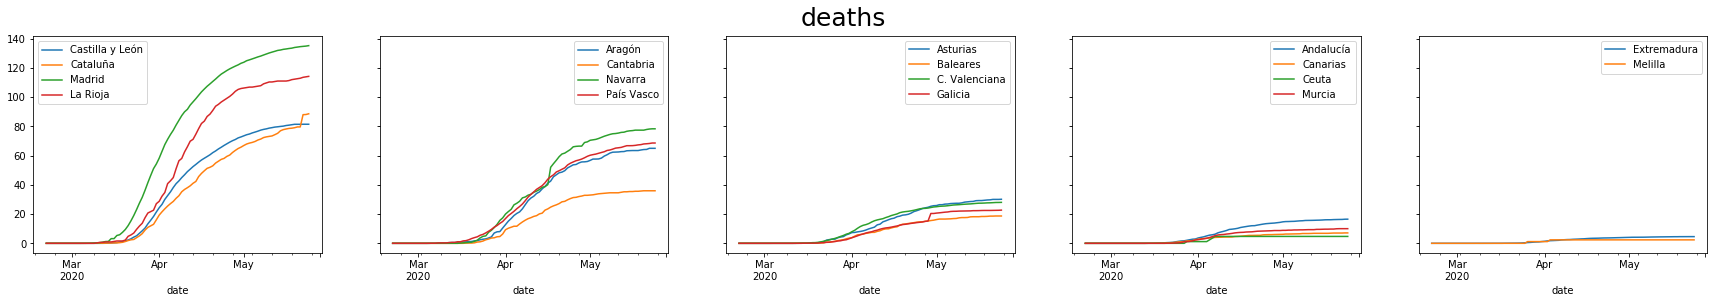

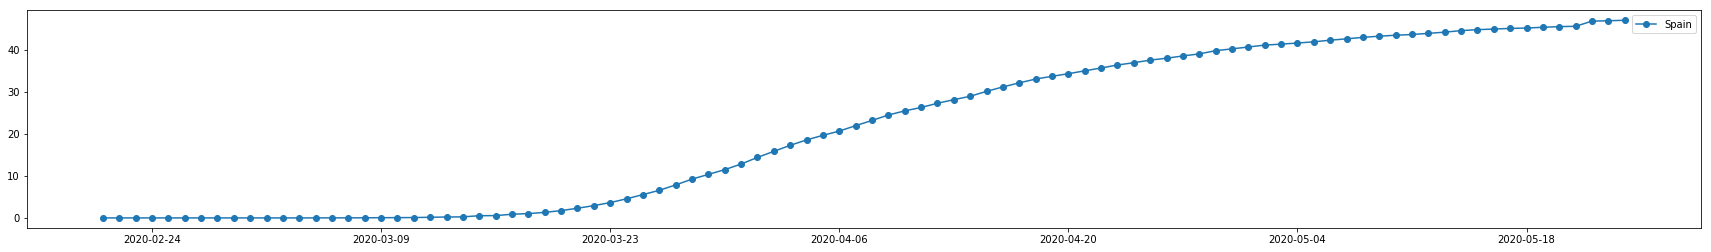

In [13]:
@interact
def plot_temporal(measure   = widgets.Dropdown( options = measures, 
                                                description = "Measure", 
                                                value = "deaths" ),
                  scale_y   = widgets.RadioButtons( options=['linear', 'log'],
                                                  value='linear',
                                                  disabled=False )):
    fig, ax = plt.subplots(1, 5, sharey=True)
    fig.set_figwidth(30)
    fig.suptitle(measure, fontsize=25)
    for i in range(1,6):
        list_CA = coronavirus_df[coronavirus_df["tile_"+measure]==i]["CA"].unique()
        for _ca in list_CA:
            ax[i-1].set_yscale(scale_y)
            coronavirus_df[coronavirus_df["CA"]==_ca].plot(x="date", y=measure+"_100", ax=ax[i-1], label=_ca)
    
    plt.figure(figsize=(30, 4))
    plt.yscale(scale_y)
    plt.plot_date(x=coronavirus_spain_df["date"], y=scale*(coronavirus_spain_df[measure]/coronavirus_spain_df["Population"]), label="Spain", linestyle='-');
    plt.legend();